<a href="https://colab.research.google.com/github/SuperCrabLover/Stochastic-Optimization-For-Zero-Order-Oracle/blob/main/Experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataLoader and calculations 

## Generating train data

In [3]:
import torch
import warnings
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

In [4]:
#Creating test data set for binary classification with 20 features 
X, y = make_classification(n_samples = 1000, n_clusters_per_class = 1, n_features=20, n_informative=20, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(y_test.size,1)
X_tensor = torch.FloatTensor(X_train)
y_tensor = torch.FloatTensor(y_train).reshape(y_train.size,1)
train_ds = TensorDataset(X_tensor, y_tensor)
batch_size = int(X_train.shape[0] / 10)
train_dl = DataLoader(train_ds, batch_size)

#Dimension of features space
DIM = 20

## Functions for calculations

In [5]:
def normalize(vec):
    """
    Makes vector have euclidean length 1 
    Arguments:
      vec: numpy array corresponding to a vector
    Returns:
      numpy array corresponding to a vector with the same direction as input with euclidean length 1
    """

    return vec / np.linalg.norm(vec)

def generate_UDV(d):
    """
    Generates uniformly distributed vector on a sphere with radius equal to 1
    Generates normally distributed vector and then normalizes it 
    Arguments:
      d: The dimension of the linear space 
    Returns:
      numpy array corresponding to a uniformly distributed vector on a sphere with radius equal to 1 in space R^d
    """

    u = np.random.normal(size = d)
    return normalize(u)

def generate_UDV_comp_wise(d):
    """
    Generates uniformly distributed vector on a sphere with radius equal to 1
    Uniformly generates an int i in [0, ..., d-1] and sets i-th component of vector to 1 
    Arguments:
      d: The dimension of the linear space 
    Returns:
      numpy array corresponding to a uniformly distributed vector on a sphere with radius equal to 1 in space R^d
    """

    i = np.random.random_integers(0, d-1)
    u = np.zeros(d)
    u[i] = 1
    return u

def _calc_stochastic_grad(model, xb, yb, loss_fn, u, d, gamma = 1e-2):
    """
    Calculates stochastic gradient of loss function by model's weights via formula:
    \grad loss = [loss(x + \gamma \cdot UDV) - loss(x - \gamma \cdot UDV)] * UDV * d/2\gamma,
    Where: 
          *UDV is uniformly distributed vector on a sphere with radius equal to 1,
          *d is linear space dimention (R^d)
    !USES generate_UDV FUNCTION!
    Arguments:
      model   : model for training
      xb      : batch from training dataset
      yb      : batch of answers from training dataset
      loss_fn : loss
      u       : UDV 
      d       : dimension of linear space
      gamma   : hyperparameter corresponding to a stepsize
    Returns:
      stochastic gradient for loss using generate_UDV
    """

    u_tens = torch.Tensor([u])
    u_tens.float()
    
    #Save inital model parametrs
    init = model.weight.data
    
    #Calculate f(x + \gamma \cdot UDV)
    model.weight.data =  init + (u_tens * gamma) 
    pred = F.sigmoid(model(xb))
    pred_plus = loss_fn(pred, yb)
    
    #Calculate f(x - \gamma \cdot UDV)
    model.weight.data =  init - (u_tens * gamma)
    pred = F.sigmoid(model(xb))
    pred_minus = loss_fn(pred, yb)
    
    #Return model into inital state
    model.weight.data = init
    
    return d * (pred_plus - pred_minus) * u_tens / (2 * gamma)

def stochastic_grad(model, xb, yb, loss_fn, gamma = 1e-2):
    """
    Calls _calc_stochastic_grad using generate_UDV
    Arguments:
      model   : model for training
      xb      : batch from training dataset
      yb      : batch of answers from training dataset
      loss_fn : loss
      gamma   : hyperparameter corresponding to a stepsize
    Returns:
      stochastic gradient for loss using generate_UDV
    """

    d = DIM
    u = generate_UDV(d)
    
    return _calc_stochastic_grad(model, xb, yb, loss_fn, u, d, gamma = 1e-2)

def stochastic_grad_comp_wise(model, xb, yb, loss_fn, gamma = 1e-2):
    """
    Calls _calc_stochastic_grad using generate_UDV
    Arguments:
      model   : model for training
      xb      : batch from training dataset
      yb      : batch of answers from training dataset
      loss_fn : loss
      gamma   : hyperparameter corresponding to a stepsize
    Returns:
      stochastic gradient for loss using generate_UDV_comp_wise
    """

    d = DIM
    u = generate_UDV_comp_wise(d)
    
    return _calc_stochastic_grad(model, xb, yb, loss_fn, u, d, gamma = 1e-2)

def two_dot_grad(model, xb, yb, loss_fn, gamma = 1e-2):
    """
    Calculates stochastic gradient of loss function by model's weights via formula:
    \grad loss = [loss(x + \gamma \cdot UDV) - loss(x)] * UDV * d/2\gamma,
    Where: 
          *UDV is uniformly distributed vector on a sphere with radius equal to 1,
          *d is linear space dimention (R^d)
    !USES generate_UDV_comp_wise FUNCTION!
    Arguments:
      model   : model for training
      xb      : batch from training dataset
      yb      : batch of answers from training dataset
      loss_fn : loss
      gamma   : hyperparameter corresponding to a stepsize
    Returns:
      stochastic gradient for loss using generate_UDV via Shamir's formula
    """

    #Shamir 2017
    d = DIM
    u = generate_UDV(d)
    u_tens = torch.Tensor([u])
    u_tens.float()
    
    #Save inital model parametrs
    init = model.weight.data
    
    #Calculate f(x)
    pred = F.sigmoid(model(xb))
    pred_zero = loss_fn(pred, yb)
    
    #Calculate f(x + \gamma \cdot UDV)
    model.weight.data =  init + (u_tens * gamma)
    pred = F.sigmoid(model(xb))
    pred_plus = loss_fn(pred, yb)
    
    #Return model into inital state
    model.weight.data = init
    
    return d * (pred_plus - pred_zero) * u_tens / (gamma)

def fit(num_epochs, model, loss_fn, optimizer, train_dl, lr = 1e-2):
    """
    Train model using optimizer
    Arguments:
      num_epochs : amount of iterations, each iteration uses whole train data separated by batches
      model      : model for training
      loss_fn    : loss
      optimizer  : funciton that will be used for calculation of gradient 
      train_dl   : data loader for training
      lr         : learning rate
    Returns:
      numpy array of losses after each minibatch iteration 
    """
    losses = []
    for epoch in range(num_epochs):
        loss = 0
        model.train() 
        for xb, yb in train_dl:
            pred = F.sigmoid(model(xb)) 
            loss = loss_fn(pred, yb) 
            with torch.no_grad():
                model.weight -= lr * optimizer(model, xb, yb, loss_fn) 
        losses.append(loss.item())
        #progress visualization
        if (epoch+1) % 1000 == 0: 
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return losses

#Simplpe tests

In [9]:
#Stochastic
model = nn.Linear(DIM, 1)
#model initialization
model.weight.data = torch.Tensor([np.ones(DIM)])
loss_fn = torch.nn.MSELoss()

print("Stochastic grad:")
traj_sgd = []
traj_sgd = fit(3000, model, loss_fn, stochastic_grad, train_dl)

Stochastic grad:
Epoch [1000/3000], Loss: 0.0419
Epoch [2000/3000], Loss: 0.0246
Epoch [3000/3000], Loss: 0.0228


In [ ]:
#Stochastic COMPWISE
model = nn.Linear(DIM, 1)
#model initialization
model.weight.data = torch.Tensor([np.ones(DIM)])
loss_fn = torch.nn.MSELoss()

print("Stochastic grad COMPWISE:")
traj_sgd_cw = []
traj_sgd_cw = fit(3000, model, loss_fn, stochastic_grad_comp_wise, train_dl)

Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0347
Epoch [2000/3000], Loss: 0.0329
Epoch [3000/3000], Loss: 0.0151


In [ ]:
#Two dot 1
model = nn.Linear(DIM, 1)
#model initialization
model.weight.data = torch.Tensor([np.ones(DIM)])
loss_fn = torch.nn.MSELoss()

print("Two dot grad:")
traj_tdg = []
traj_tdg = fit(3000, model, loss_fn, two_dot_grad, train_dl)

Two dot grad:
Epoch [1000/3000], Loss: 0.0426
Epoch [2000/3000], Loss: 0.0281
Epoch [3000/3000], Loss: 0.0078


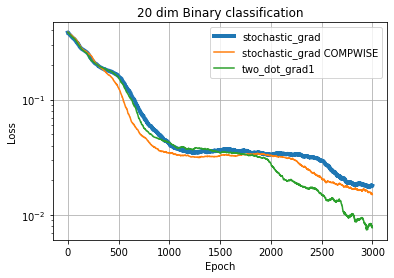

In [ ]:
plt.plot(np.array(range(len(traj_sgd))), traj_sgd, linewidth = 4, label = "stochastic_grad")
plt.plot(np.array(range(len(traj_sgd_cw))), traj_sgd_cw, label = "stochastic_grad COMPWISE")
plt.plot(np.array(range(len(traj_tdg))), traj_tdg, label = "two_dot_grad1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.title("20 dim Binary classification")
plt.legend()
plt.grid()
plt.show()

#Weights and biases graphs

In [6]:
!pip install wandb -qU

     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 153 kB 41.5 MB/s 
     |████████████████████████████████| 181 kB 37.6 MB/s 
     |████████████████████████████████| 63 kB 756 kB/s 


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
def fit_wandb(num_epochs, model, loss_fn, optimizer, train_dl, name, lr = 1e-2):
    """
    Train model using optimizer
    Arguments:
      num_epochs : amount of iterations, each iteration uses whole train data separated by batches
      model      : model for training
      loss_fn    : loss
      optimizer  : funciton that will be used for calculation of gradient 
      train_dl   : data loader for training
      lr         : learning rate
    Returns:
      numpy array of losses after each minibatch iteration 
    """
    losses = []
    i = 0 
    for epoch in range(num_epochs):
        loss = 0
        model.train()
        for xb, yb in train_dl:
            i += 1
            pred = F.sigmoid(model(xb)) 
            loss = loss_fn(pred, yb) 
            with torch.no_grad():
                model.weight -= lr * optimizer(model, xb, yb, loss_fn) 
        losses.append(loss.item())
        wandb.log({f"{name}": loss.item(), "x": i})
        #progress visualization
        if (epoch+1) % 1000 == 0: 
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return losses

In [21]:
N = 12
for _ in range(N):
    wandb.init(
      # Set the project where this run will be logged
      project="Stochastic Smoothing", 
      entity="crab_soda", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"comp_stohastic_grad_compwise_two_dot {_}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 1e-2,
      "architecture": "nn.Linear",
      "dataset": "sklearn_artificial",
      "epochs": 3000,
      })
    print(f"iteration: {_}")
    #Stochastic
    model = nn.Linear(DIM,1)
    model.weight.data = torch.Tensor([np.ones(DIM)])
    loss_fn = torch.nn.MSELoss()

    name = "Stochastic grad"
    print(f"{name}:")
    traj_sgd = []
    traj_sgd = fit_wandb(3000, model, loss_fn, stochastic_grad, train_dl, name)

    
    #Stochastic COMPWISE
    model = nn.Linear(DIM,1)
    model.weight.data = torch.Tensor([np.ones(DIM)])
    loss_fn = torch.nn.MSELoss()

    name = "Stochastic grad COMPWISE"
    print(f"{name}:")
    traj_sgd_cw = []
    traj_sgd_cw = fit_wandb(3000, model, loss_fn, stochastic_grad_comp_wise, train_dl, name)
    
    #Two dot 1
    model = nn.Linear(DIM,1)
    model.weight.data = torch.Tensor([np.ones(DIM)])
    loss_fn = torch.nn.MSELoss()

    name = "Two dot grad"
    print(f"{name}:")
    traj_tdg = []
    traj_tdg = fit_wandb(3000, model, loss_fn, two_dot_grad, train_dl, name)

wandb.finish()

iteration: 0
Stochastic grad:
Epoch [1000/3000], Loss: 0.0852
Epoch [2000/3000], Loss: 0.0419
Epoch [3000/3000], Loss: 0.0317
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0935
Epoch [2000/3000], Loss: 0.0382
Epoch [3000/3000], Loss: 0.0338
Two dot grad:
Epoch [1000/3000], Loss: 0.0779
Epoch [2000/3000], Loss: 0.0400
Epoch [3000/3000], Loss: 0.0334


Stochastic grad,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03171
Stochastic grad COMPWISE,0.03382
Two dot grad,0.03336
x,30000


iteration: 1
Stochastic grad:
Epoch [1000/3000], Loss: 0.0850
Epoch [2000/3000], Loss: 0.0371
Epoch [3000/3000], Loss: 0.0311
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0768
Epoch [2000/3000], Loss: 0.0375
Epoch [3000/3000], Loss: 0.0350
Two dot grad:
Epoch [1000/3000], Loss: 0.0888
Epoch [2000/3000], Loss: 0.0363
Epoch [3000/3000], Loss: 0.0339


Stochastic grad,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▅▅▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03107
Stochastic grad COMPWISE,0.03499
Two dot grad,0.03393
x,30000


iteration: 2
Stochastic grad:
Epoch [1000/3000], Loss: 0.0892
Epoch [2000/3000], Loss: 0.0327
Epoch [3000/3000], Loss: 0.0289
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0831
Epoch [2000/3000], Loss: 0.0355
Epoch [3000/3000], Loss: 0.0320
Two dot grad:
Epoch [1000/3000], Loss: 0.0869
Epoch [2000/3000], Loss: 0.0379
Epoch [3000/3000], Loss: 0.0345


Stochastic grad,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.02892
Stochastic grad COMPWISE,0.03202
Two dot grad,0.0345
x,30000


iteration: 3
Stochastic grad:
Epoch [1000/3000], Loss: 0.0933
Epoch [2000/3000], Loss: 0.0413
Epoch [3000/3000], Loss: 0.0333
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0857
Epoch [2000/3000], Loss: 0.0351
Epoch [3000/3000], Loss: 0.0274
Two dot grad:
Epoch [1000/3000], Loss: 0.0559
Epoch [2000/3000], Loss: 0.0347
Epoch [3000/3000], Loss: 0.0291


Stochastic grad,█▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03331
Stochastic grad COMPWISE,0.02737
Two dot grad,0.02906
x,30000


iteration: 4
Stochastic grad:
Epoch [1000/3000], Loss: 0.0658
Epoch [2000/3000], Loss: 0.0379
Epoch [3000/3000], Loss: 0.0324
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0642
Epoch [2000/3000], Loss: 0.0351
Epoch [3000/3000], Loss: 0.0304
Two dot grad:
Epoch [1000/3000], Loss: 0.0939
Epoch [2000/3000], Loss: 0.0386
Epoch [3000/3000], Loss: 0.0331


Stochastic grad,█▆▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03238
Stochastic grad COMPWISE,0.03044
Two dot grad,0.03309
x,30000


iteration: 5
Stochastic grad:
Epoch [1000/3000], Loss: 0.0724
Epoch [2000/3000], Loss: 0.0356
Epoch [3000/3000], Loss: 0.0290
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0863
Epoch [2000/3000], Loss: 0.0379
Epoch [3000/3000], Loss: 0.0316
Two dot grad:
Epoch [1000/3000], Loss: 0.0542
Epoch [2000/3000], Loss: 0.0372
Epoch [3000/3000], Loss: 0.0285


Stochastic grad,█▆▅▅▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.02903
Stochastic grad COMPWISE,0.03161
Two dot grad,0.02854
x,30000


iteration: 6
Stochastic grad:
Epoch [1000/3000], Loss: 0.0716
Epoch [2000/3000], Loss: 0.0382
Epoch [3000/3000], Loss: 0.0287
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0737
Epoch [2000/3000], Loss: 0.0337
Epoch [3000/3000], Loss: 0.0306
Two dot grad:
Epoch [1000/3000], Loss: 0.1034
Epoch [2000/3000], Loss: 0.0395
Epoch [3000/3000], Loss: 0.0330


Stochastic grad,█▆▅▅▅▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▅▅▅▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.02871
Stochastic grad COMPWISE,0.03057
Two dot grad,0.03298
x,30000


iteration: 7
Stochastic grad:
Epoch [1000/3000], Loss: 0.0717
Epoch [2000/3000], Loss: 0.0345
Epoch [3000/3000], Loss: 0.0295
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0836
Epoch [2000/3000], Loss: 0.0344
Epoch [3000/3000], Loss: 0.0308
Two dot grad:
Epoch [1000/3000], Loss: 0.0845
Epoch [2000/3000], Loss: 0.0354
Epoch [3000/3000], Loss: 0.0308


Stochastic grad,█▆▆▅▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▅▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.0295
Stochastic grad COMPWISE,0.03077
Two dot grad,0.03079
x,30000


iteration: 8
Stochastic grad:
Epoch [1000/3000], Loss: 0.0835
Epoch [2000/3000], Loss: 0.0443
Epoch [3000/3000], Loss: 0.0333
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0885
Epoch [2000/3000], Loss: 0.0360
Epoch [3000/3000], Loss: 0.0310
Two dot grad:
Epoch [1000/3000], Loss: 0.0976
Epoch [2000/3000], Loss: 0.0373
Epoch [3000/3000], Loss: 0.0323


Stochastic grad,█▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03328
Stochastic grad COMPWISE,0.03101
Two dot grad,0.03232
x,30000


iteration: 9
Stochastic grad:
Epoch [1000/3000], Loss: 0.0856
Epoch [2000/3000], Loss: 0.0364
Epoch [3000/3000], Loss: 0.0280
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0808
Epoch [2000/3000], Loss: 0.0359
Epoch [3000/3000], Loss: 0.0309
Two dot grad:
Epoch [1000/3000], Loss: 0.0874
Epoch [2000/3000], Loss: 0.0357
Epoch [3000/3000], Loss: 0.0316


Stochastic grad,█▆▆▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.02797
Stochastic grad COMPWISE,0.03092
Two dot grad,0.03157
x,30000


iteration: 10
Stochastic grad:
Epoch [1000/3000], Loss: 0.0764
Epoch [2000/3000], Loss: 0.0362
Epoch [3000/3000], Loss: 0.0300
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0677
Epoch [2000/3000], Loss: 0.0341
Epoch [3000/3000], Loss: 0.0264
Two dot grad:
Epoch [1000/3000], Loss: 0.0672
Epoch [2000/3000], Loss: 0.0337
Epoch [3000/3000], Loss: 0.0286


Stochastic grad,█▆▆▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03005
Stochastic grad COMPWISE,0.02641
Two dot grad,0.0286
x,30000


iteration: 11
Stochastic grad:
Epoch [1000/3000], Loss: 0.0806
Epoch [2000/3000], Loss: 0.0413
Epoch [3000/3000], Loss: 0.0328
Stochastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0849
Epoch [2000/3000], Loss: 0.0358
Epoch [3000/3000], Loss: 0.0330
Two dot grad:
Epoch [1000/3000], Loss: 0.0895
Epoch [2000/3000], Loss: 0.0347
Epoch [3000/3000], Loss: 0.0309


Stochastic grad,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Stochastic grad COMPWISE,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Two dot grad,█▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▃▄▅▅▆▆▇▇█
Stochastic grad,0.03278
Stochastic grad COMPWISE,0.03298
Two dot grad,0.03089
x,30000
